## LAN distilation

Goal: distill flow -> MLP for efficient inference

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
from torch import Tensor

from sbi.analysis import pairplot
from sbi.inference import MNLE, MCMCPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.inference.potentials.likelihood_based_potential import (
    MixedLikelihoodBasedPotential,
)
from sbi.utils import MultipleIndependent, mcmc_transform
from sbi.utils.conditional_density_utils import ConditionedPotential
from sbi.utils.metrics import c2st
from sbi.utils.torchutils import atleast_2d

from sbi.utils import BoxUniform


import os
import pickle

import arviz as az
import jax.numpy as jnp
import lanfactory as lf
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

import hssm
from hssm.config import ModelConfig

torch.manual_seed(42)

Step 1: Set up simulator

In [2]:
from ssms.basic_simulators.simulator import simulator as ssm_simulator

def simulator(theta: Tensor) -> Tensor:
    """
    We wrap the ssms simulator for the proper interface for sbi
    """
    xs = []
    for t in tqdm(theta):
        sim_out = ssm_simulator(
            model="ddm",
            theta={ "v": t[0].item(),
                    "a": t[1].item(),
                    "z": t[2].item(),
                    "t": t[3].item() },
            n_samples=1,
            smooth_unif=False,
        )
        rt = sim_out["rts"].squeeze()
        choice = sim_out["choices"].squeeze()

        # TODO: decide if this is okay 
        # convert from {−1, +1} to {0, 1}
        choice[choice == -1] = 0

        x = torch.from_numpy(np.array([rt, choice]))
        xs.append(x)

    xs = torch.stack(xs, dim=0).to(torch.float32)
    return xs

Step 2: Train density estimator using SBI 

In [3]:
# define out prior bounds on the parameters [v, a, z, t]
lower_bounds = torch.tensor([-3.0, 0.3, 0.1, 0.0])
upper_bounds = torch.tensor([3.0, 2.5, 0.9, 2.0])
prior = BoxUniform(low=lower_bounds, high=upper_bounds)


In [4]:
# Generate training data
num_simulations = 100000
theta_train = prior.sample((num_simulations,))
x_train = simulator(theta_train)

# Train MNLE and obtain MCMC-based posterior.
trainer = MNLE(prior=prior)
estimator = trainer.append_simulations(theta_train, x_train).train()

100%|██████████| 100000/100000 [00:26<00:00, 3714.73it/s]
/Users/hayden/miniconda3/envs/lans/lib/python3.11/site-packages/sbi/neural_nets/factory.py:207: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-k columns (e.g., reaction times) and categorical data in the last k columns (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  return model_builders[model](batch_x=batch_x, batch_y=batch_theta, **kwargs)
/Users/hayden/miniconda3/envs/lans/lib/python3.11/site-packages/sbi/neural_nets/net_builders/mnle.py:156: UserWarning: Inferring num_categories from batch_x. Ensure all categories are present.
  discrete_net = build_categoricalmassestimator(


 Neural network successfully converged after 76 epochs.

In [5]:
# get a test theta from the prior
test_theta = prior.sample((1,))
# generate synthetic data from MNLE
synthetic_data = estimator.sample(sample_shape=(1000,), condition=test_theta)
# and real data using the simulator. 
real_data = simulator(test_theta.repeat(1000, 1))

100%|██████████| 1000/1000 [00:00<00:00, 2614.71it/s]


In [6]:
synthetic_data = synthetic_data[:,0,:]

print(real_data.shape)
print(synthetic_data.shape)

torch.Size([1000, 2])
torch.Size([1000, 2])


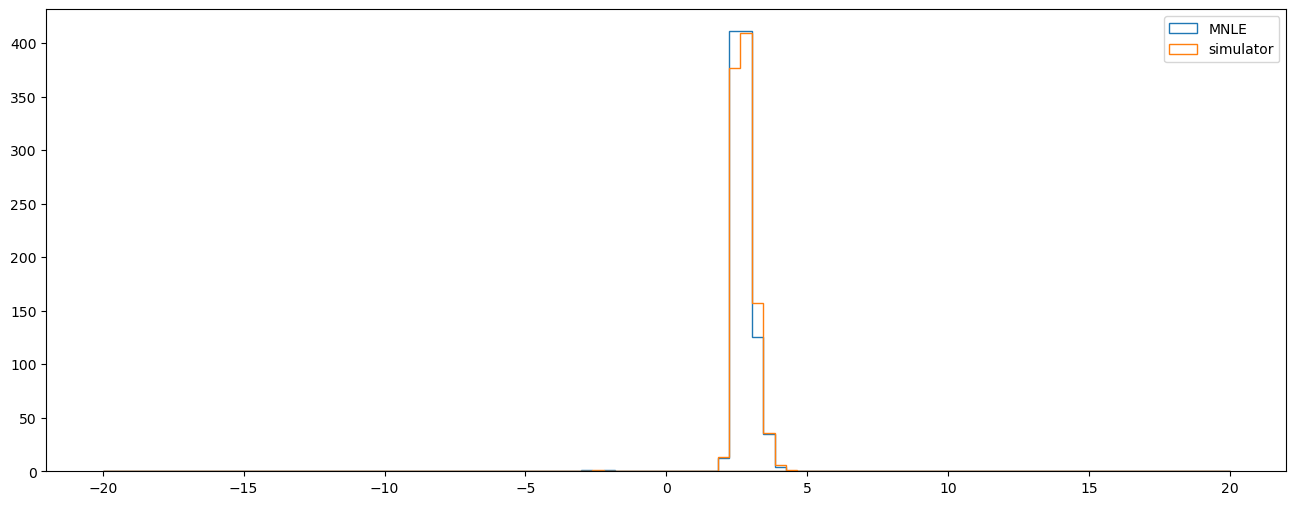

In [ ]:
# compare visually
plt.figure(figsize=(12, 4))
bins = torch.linspace(-20, 20, 100)

# one compact way to plot this data is to encode the choice with the sign of the reaction time:
# let's create masks selecting the 0-choices.
synthetic_choice_mask = synthetic_data[:, 1] == 0
real_choice_mask = real_data[:, 1] == 0

plt.hist(-synthetic_data[synthetic_choice_mask, 0], bins=bins, histtype="step");
plt.hist(-real_data[real_choice_mask, 0], bins=bins, histtype="step");
plt.legend(["MNLE", "simulator"])
plt.hist(synthetic_data[~synthetic_choice_mask, 0], bins=bins, histtype="step", 
         color="C0");
plt.hist(real_data[~real_choice_mask, 0], bins=bins, histtype="step", 
         color="C1");

Check posterior

In [20]:
# Define MCMC parameters
mcmc_kwargs = dict(
    num_chains=20,
    warmup_steps=100,
    method="slice_np_vectorized",
    init_strategy="proposal",
)

# Build posterior from the trained estimator and prior.
mnle_posterior = trainer.build_posterior(prior=prior)

/Users/hayden/miniconda3/envs/lans/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


In [21]:
# Test parameter recovery
n_posterior_samples = 100000
theta_true = prior.sample((1,))
x_obs = simulator(theta_true)
mnle_posterior.set_default_x(x_obs)
samples = mnle_posterior.sample((n_posterior_samples,))
map = mnle_posterior.map().squeeze()

100%|██████████| 1/1 [00:00<00:00, 1069.43it/s]


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/105000 [00:00<?, ?it/s]

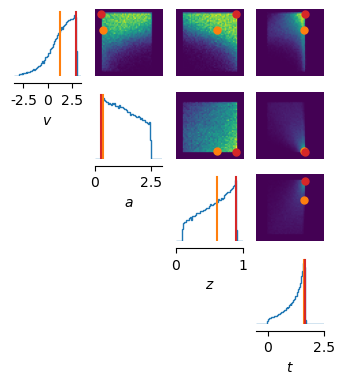

In [22]:
lower_bounds = torch.tensor([-3.5, 0, 0, -.5])
upper_bounds = torch.tensor([3.5, 3, 1, 2.5])

fig, ax = pairplot(samples,
             limits=list(zip(lower_bounds, upper_bounds)),
             figsize=(4, 4),
             labels=[r"$v$", r"$a$", r"$z$", r"$t$"], 
             points=[theta_true, map],
             );

/var/folders/px/fw8yx6952d98rglp3pvmk66w0000gn/T/ipykernel_62281/3955300817.py:2: DeprecationWarning: you passed deprecated arguments **kwargs: ['kde_offdiag', 'kde_diag', 'contour_offdiag'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, ax = pairplot([


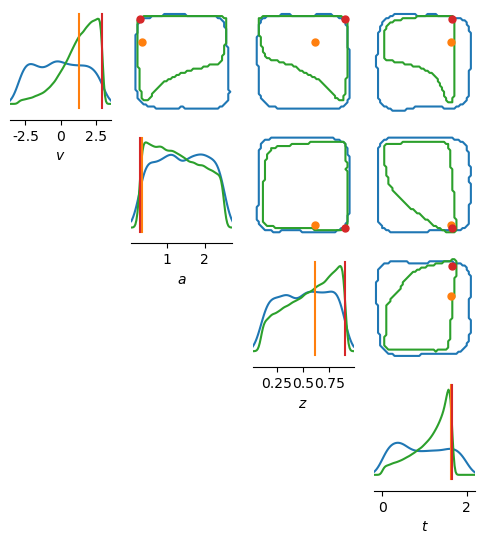

In [23]:
# Plot them in one pairplot as contours (obtained via KDE on the samples).
fig, ax = pairplot([
    prior.sample((1000,)),
    samples,
], 
    figsize=(6, 6),
    diag="kde",
    upper="contour", 
    kde_offdiag=dict(bins=50),
    kde_diag=dict(bins=100),
    contour_offdiag=dict(levels=[0.95]),
    labels=[r"$v$", r"$a$", r"$z$", r"$t$"], 
    points=[theta_true, map],
);

Distill MLNE into LAN

In [27]:
print(theta_train.shape)
print(x_train.shape)

type(estimator)

torch.Size([100000, 4])
torch.Size([100000, 2])


sbi.neural_nets.estimators.mixed_density_estimator.MixedDensityEstimator

In [60]:
with torch.no_grad():
    log_p = estimator.log_prob(x_train.unsqueeze(0), condition=theta_train).squeeze(0)

In [66]:
data = torch.concat((theta_train, x_train), dim=1)
labels = log_p

print(data.shape)
print(labels.shape)

torch.Size([100000, 6])
torch.Size([100000])


In [67]:
from lanfactory.trainers import MLPJax, ModelTrainerJaxMLP
from torch.utils.data import DataLoader, TensorDataset
labels = labels.reshape(-1,1)

# 2) Build DataLoaders
batch_size = 128
ds = TensorDataset(data, labels)
train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(ds, batch_size=batch_size, shuffle=False)

# tell the trainer how big each input is
train_dl.dataset.input_dim = data.shape[1]
valid_dl.dataset.input_dim = data.shape[1]

# dummy placeholders so that .train_and_evaluate doesn’t crash on saving
train_dl.dataset.data_generator_config = {}
valid_dl.dataset.data_generator_config = {}
train_dl.dataset.file_ids = []
valid_dl.dataset.file_ids = []


# now instantiate and run
train_config = {"n_epochs":50, "loss":"mse"}
mlp = MLPJax(
    layer_sizes=(64,64,1), 
    activations = ("relu","relu","linear"), 
    train=True, 
    train_output_type="logprob"
    )
trainer = ModelTrainerJaxMLP(train_config, mlp, train_dl, valid_dl, seed=0)
final_state = trainer.train_and_evaluate(
    output_folder="./jax_mlp_runs",
    output_file_id="lan_mlp",
    run_id="run1",
    wandb_on=False,
    save_all=False,
)

Found folder:  .
Moving on...
Found folder:  ./jax_mlp_runs
Moving on...
Epoch: 0 of 50
Training - Step: 0 of 782 - Loss: 1.0006938
Epoch 0/50 time: 0.3606986999511719s
Validation - Step: 0 of 782 - Loss: 0.4142249
Epoch 0/50 time: 0.22378206253051758s
Epoch: 0 / 50, test_loss: 1.3253995180130005
Epoch: 1 of 50
Training - Step: 0 of 782 - Loss: 0.3979168
Epoch 1/50 time: 0.2519829273223877s
Validation - Step: 0 of 782 - Loss: 0.25815862
Epoch 1/50 time: 0.19742918014526367s
Epoch: 1 / 50, test_loss: 1.0646599531173706
Epoch: 2 of 50
Training - Step: 0 of 782 - Loss: 0.5728116
Epoch 2/50 time: 0.24200105667114258s
Validation - Step: 0 of 782 - Loss: 0.1798294
Epoch 2/50 time: 0.20090603828430176s
Epoch: 2 / 50, test_loss: 0.9218548536300659
Epoch: 3 of 50
Training - Step: 0 of 782 - Loss: 0.2459876
Epoch 3/50 time: 0.25293421745300293s
Validation - Step: 0 of 782 - Loss: 0.18574037
Epoch 3/50 time: 0.19408273696899414s
Epoch: 3 / 50, test_loss: 1.0976041555404663
Epoch: 4 of 50
Training

In [68]:
final_state

TrainState(step=Array(39100, dtype=int32, weak_type=True), apply_fn=<bound method Module.apply of MLPJax(
    # attributes
    network_type_dict = frozendict.frozendict({'logprob': 'lan', 'logits': 'cpn'})
    layer_sizes = (64, 64, 1)
    activations = ('relu', 'relu', 'linear')
    train = True
    train_output_type = 'logprob'
)>, params={'params': {'layers_0': {'bias': Array([-1.6472563 ,  0.8372931 ,  0.04473353, -1.1842738 , -0.17674512,
       -0.3983118 ,  3.0420344 , -3.5718892 ,  0.74720633,  0.16616465,
        0.3177996 , -0.15337044, -0.12511793, -3.2521353 ,  0.46548545,
       -2.0480497 ,  0.14832355, -3.6147704 ,  0.31215426, -3.9150333 ,
        0.8744148 ,  0.21064366, -3.4501626 , -2.1732438 , -0.13464326,
       -0.524463  , -1.2078909 ,  1.2859386 ,  1.0084356 ,  0.30609486,
       -0.20251976, -0.0634827 , -3.7972398 , -1.8797321 ,  1.2875277 ,
        0.917445  ,  1.2460032 ,  1.6349336 , -1.8332672 ,  0.73342496,
       -0.5028431 ,  0.35581067,  1.1830076 , -0

Use HSSM

In [71]:
jax_logp, _ = mlp.make_forward_partial(
    seed=42,
    input_dim=4 + 2,  # n-parameters (v,a,z,t) + n-data (rts and choices)
    state="./jax_mlp_runs/run1_lan_lan_mlp__train_state.jax",
    add_jitted=True,
)

In [72]:
# Testing the signature of the JAX function 1
n_trials = 10
jax_logp(np.tile(np.array([1.0, 1.5, 0.5, 0.3, 1.6, 1.0]), (n_trials, 1)))

Array([[-0.9485389],
       [-0.9485389],
       [-0.9485389],
       [-0.9485389],
       [-0.9485389],
       [-0.9485389],
       [-0.9485389],
       [-0.9485389],
       [-0.9485389],
       [-0.9485389]], dtype=float32)

In [73]:
# Testing the signature of the JAX function 2
n_dim_model_parameters = 4
n_dim_data = 2
in_ = jnp.zeros((n_trials, n_dim_model_parameters + n_dim_data))
out = jax_logp(in_)
print(out.shape)

(10, 1)


In [74]:
from functools import partial
from ssms.basic_simulators.simulator import simulator
from hssm.utils import decorate_atomic_simulator


def sim_wrapper(simulator_fun, theta, model, n_samples, random_state, **kwargs):
    """Wrap a simulator function to match HSSM's expected interface.

    Parameters
    ----------
    simulator_fun : callable
        The simulator function to wrap
    theta : array-like
        Model parameters, shape (n_trials, n_parameters)
    model : str
        Name of the model to simulate
    n_samples : int
        Number of samples to generate per trial
    random_state : int or numpy.random.Generator
        Random seed or random number generator
    **kwargs
        Additional keyword arguments passed to simulator_fun

    Returns
    -------
    array-like
        Array of shape (n_trials, 2) containing reaction times and choices
        stacked column-wise
    """
    out = simulator_fun(
        theta=theta,
        model=model,
        n_samples=n_samples,
        random_state=random_state,
        **kwargs,
    )
    return np.column_stack([out["rts"], out["choices"]])


my_wrapped_simulator = partial(
    sim_wrapper, simulator_fun=simulator, model="ddm", n_samples=1
)

decorated_simulator = decorate_atomic_simulator(
    model_name="ddm", choices=[-1, 1], obs_dim=2
)(my_wrapped_simulator)

In [75]:
decorated_simulator(
    theta=np.tile(np.array([1.0, 1.5, 0.5, 0.3]), (10, 1)), random_state=42
)

array([[ 2.12210941,  1.        ],
       [ 2.6890626 ,  1.        ],
       [ 1.28667963,  1.        ],
       [ 1.16390681,  1.        ],
       [ 1.42591691,  1.        ],
       [ 1.14748347,  1.        ],
       [ 1.47392309,  1.        ],
       [ 0.88049531, -1.        ],
       [ 1.78516912,  1.        ],
       [ 1.20256472,  1.        ]])

In [76]:
from hssm.distribution_utils.dist import (
    make_distribution,
    make_hssm_rv,
    make_likelihood_callable,
)

# Step 1: Define a pytensor RandomVariable
CustomRV = make_hssm_rv(
    simulator_fun=decorated_simulator, list_params=["v", "a", "z", "t"]
)

# Step 2: Define a likelihood function
logp_jax_op = make_likelihood_callable(
    loglik=jax_logp,
    loglik_kind="approx_differentiable",
    backend="jax",
    params_is_reg=[False, False, False, False],
    params_only=False,
)

# Step 3: Define a distribution
CustomDistribution = make_distribution(
    rv=CustomRV,
    loglik=logp_jax_op,
    list_params=["v", "a", "z", "t"],
    bounds=dict(v=(-3, 3), a=(0.5, 3.0), z=(0.1, 0.9), t=(0, 2.0)),
)

In [80]:
import hssm 
import pymc as pm

# simulate some data from the model
obs_ddm = hssm.simulate_data(
    theta=dict(v=1.0, a=1.5, t=0.3, z=0.5), model="ddm", size=1000
)

# Test via basic pymc model
with pm.Model() as model:
    v = pm.Normal("v", mu=0, sigma=1)
    a = pm.Uniform("a", lower=0.5, upper=3.0)
    z = pm.Beta("z", alpha=10, beta=10)
    t = pm.Weibull("t", alpha=0.5, beta=1.0)
    CustomDistribution("custom", v=v, a=a, z=z, t=t, observed=obs_ddm.values)
with model:
    idata = pm.sample(draws=1000, tune=200, chains=1, nuts_sampler="numpyro")

sample: 100%|██████████| 1200/1200 [00:05<00:00, 229.84it/s, 7 steps of size 4.09e-01. acc. prob=0.92] 
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

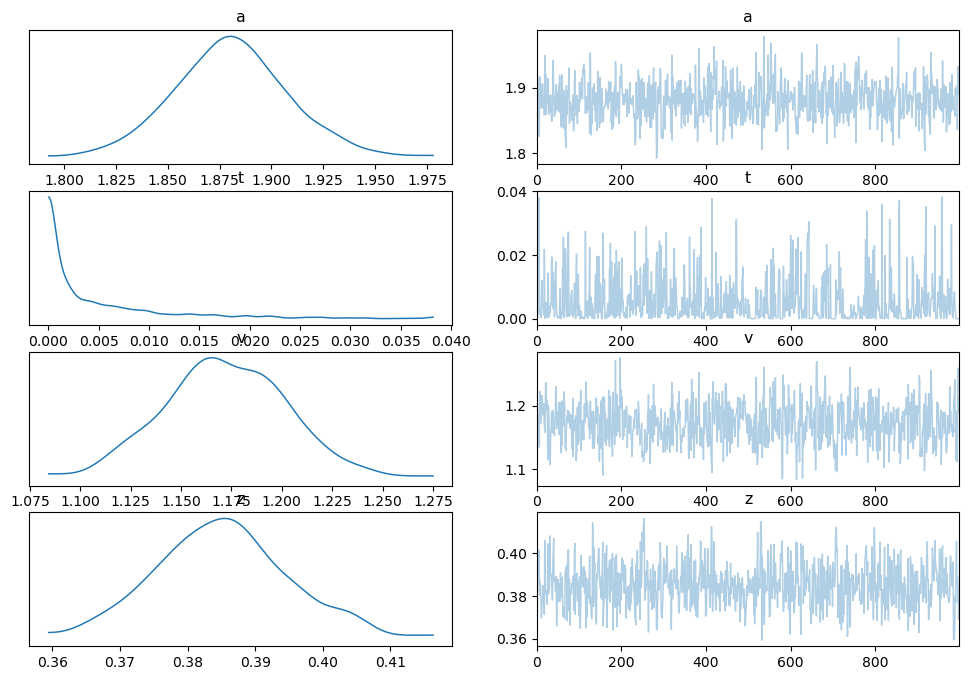

In [83]:
az.plot_trace(idata)

In [84]:
# Define model config
my_custom_model_config = ModelConfig(
    response=["rt", "response"],
    list_params=["v", "a", "z", "t"],
    bounds={
        "v": (-2.5, 2.5),
        "a": (1.0, 3.0),
        "z": (0.0, 0.9),
        "t": (0.001, 2),
    },
    rv=decorated_simulator,
    backend="jax",
    choices=[-1, 1],
)

You have specified the `lapse` argument to include a lapse distribution, but `p_outlier` is set to either 0 or None. Your lapse distribution will be ignored.
Model initialized successfully.


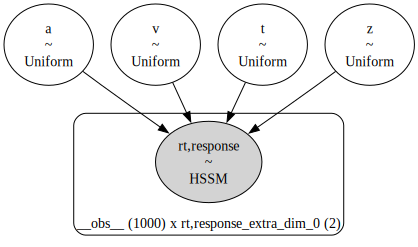

In [86]:
# Define the HSSM model
model = hssm.HSSM(
    data=obs_ddm,
    model="my_new_model",  # some name for the model
    model_config=my_custom_model_config,
    loglik_kind="approx_differentiable",  # use the blackbox loglik
    loglik=jax_logp,
    p_outlier=0,
)

model.graph()

In [87]:
# Test sampling
model.sample(draws=500, tune=200, nuts_sampler="numpyro", discard_tuned_samples=False)

Using default initvals. 



/Users/hayden/miniconda3/envs/lans/lib/python3.11/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 700/700 [00:02<00:00, 319.06it/s, 7 steps of size 4.36e-01. acc. prob=0.93] 
/Users/hayden/miniconda3/envs/lans/lib/python3.11/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 2000/2000 [00:00<00:00, 5805.51it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

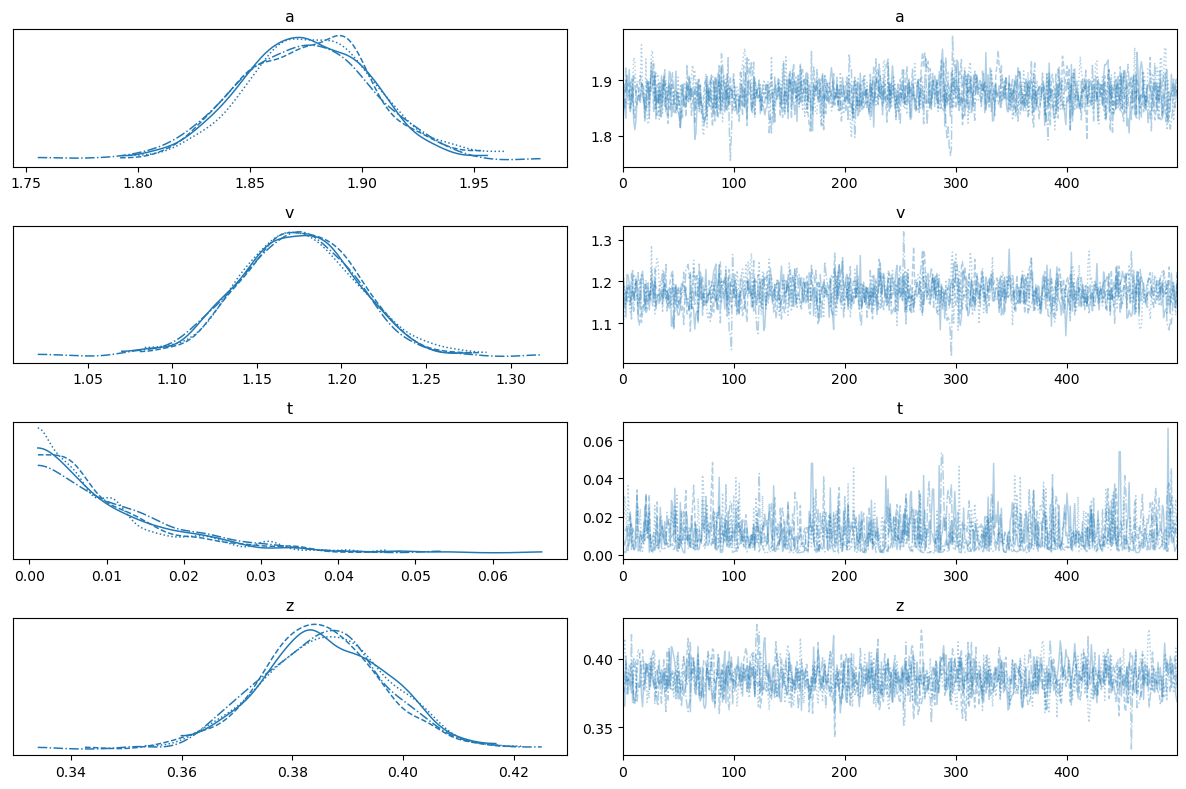

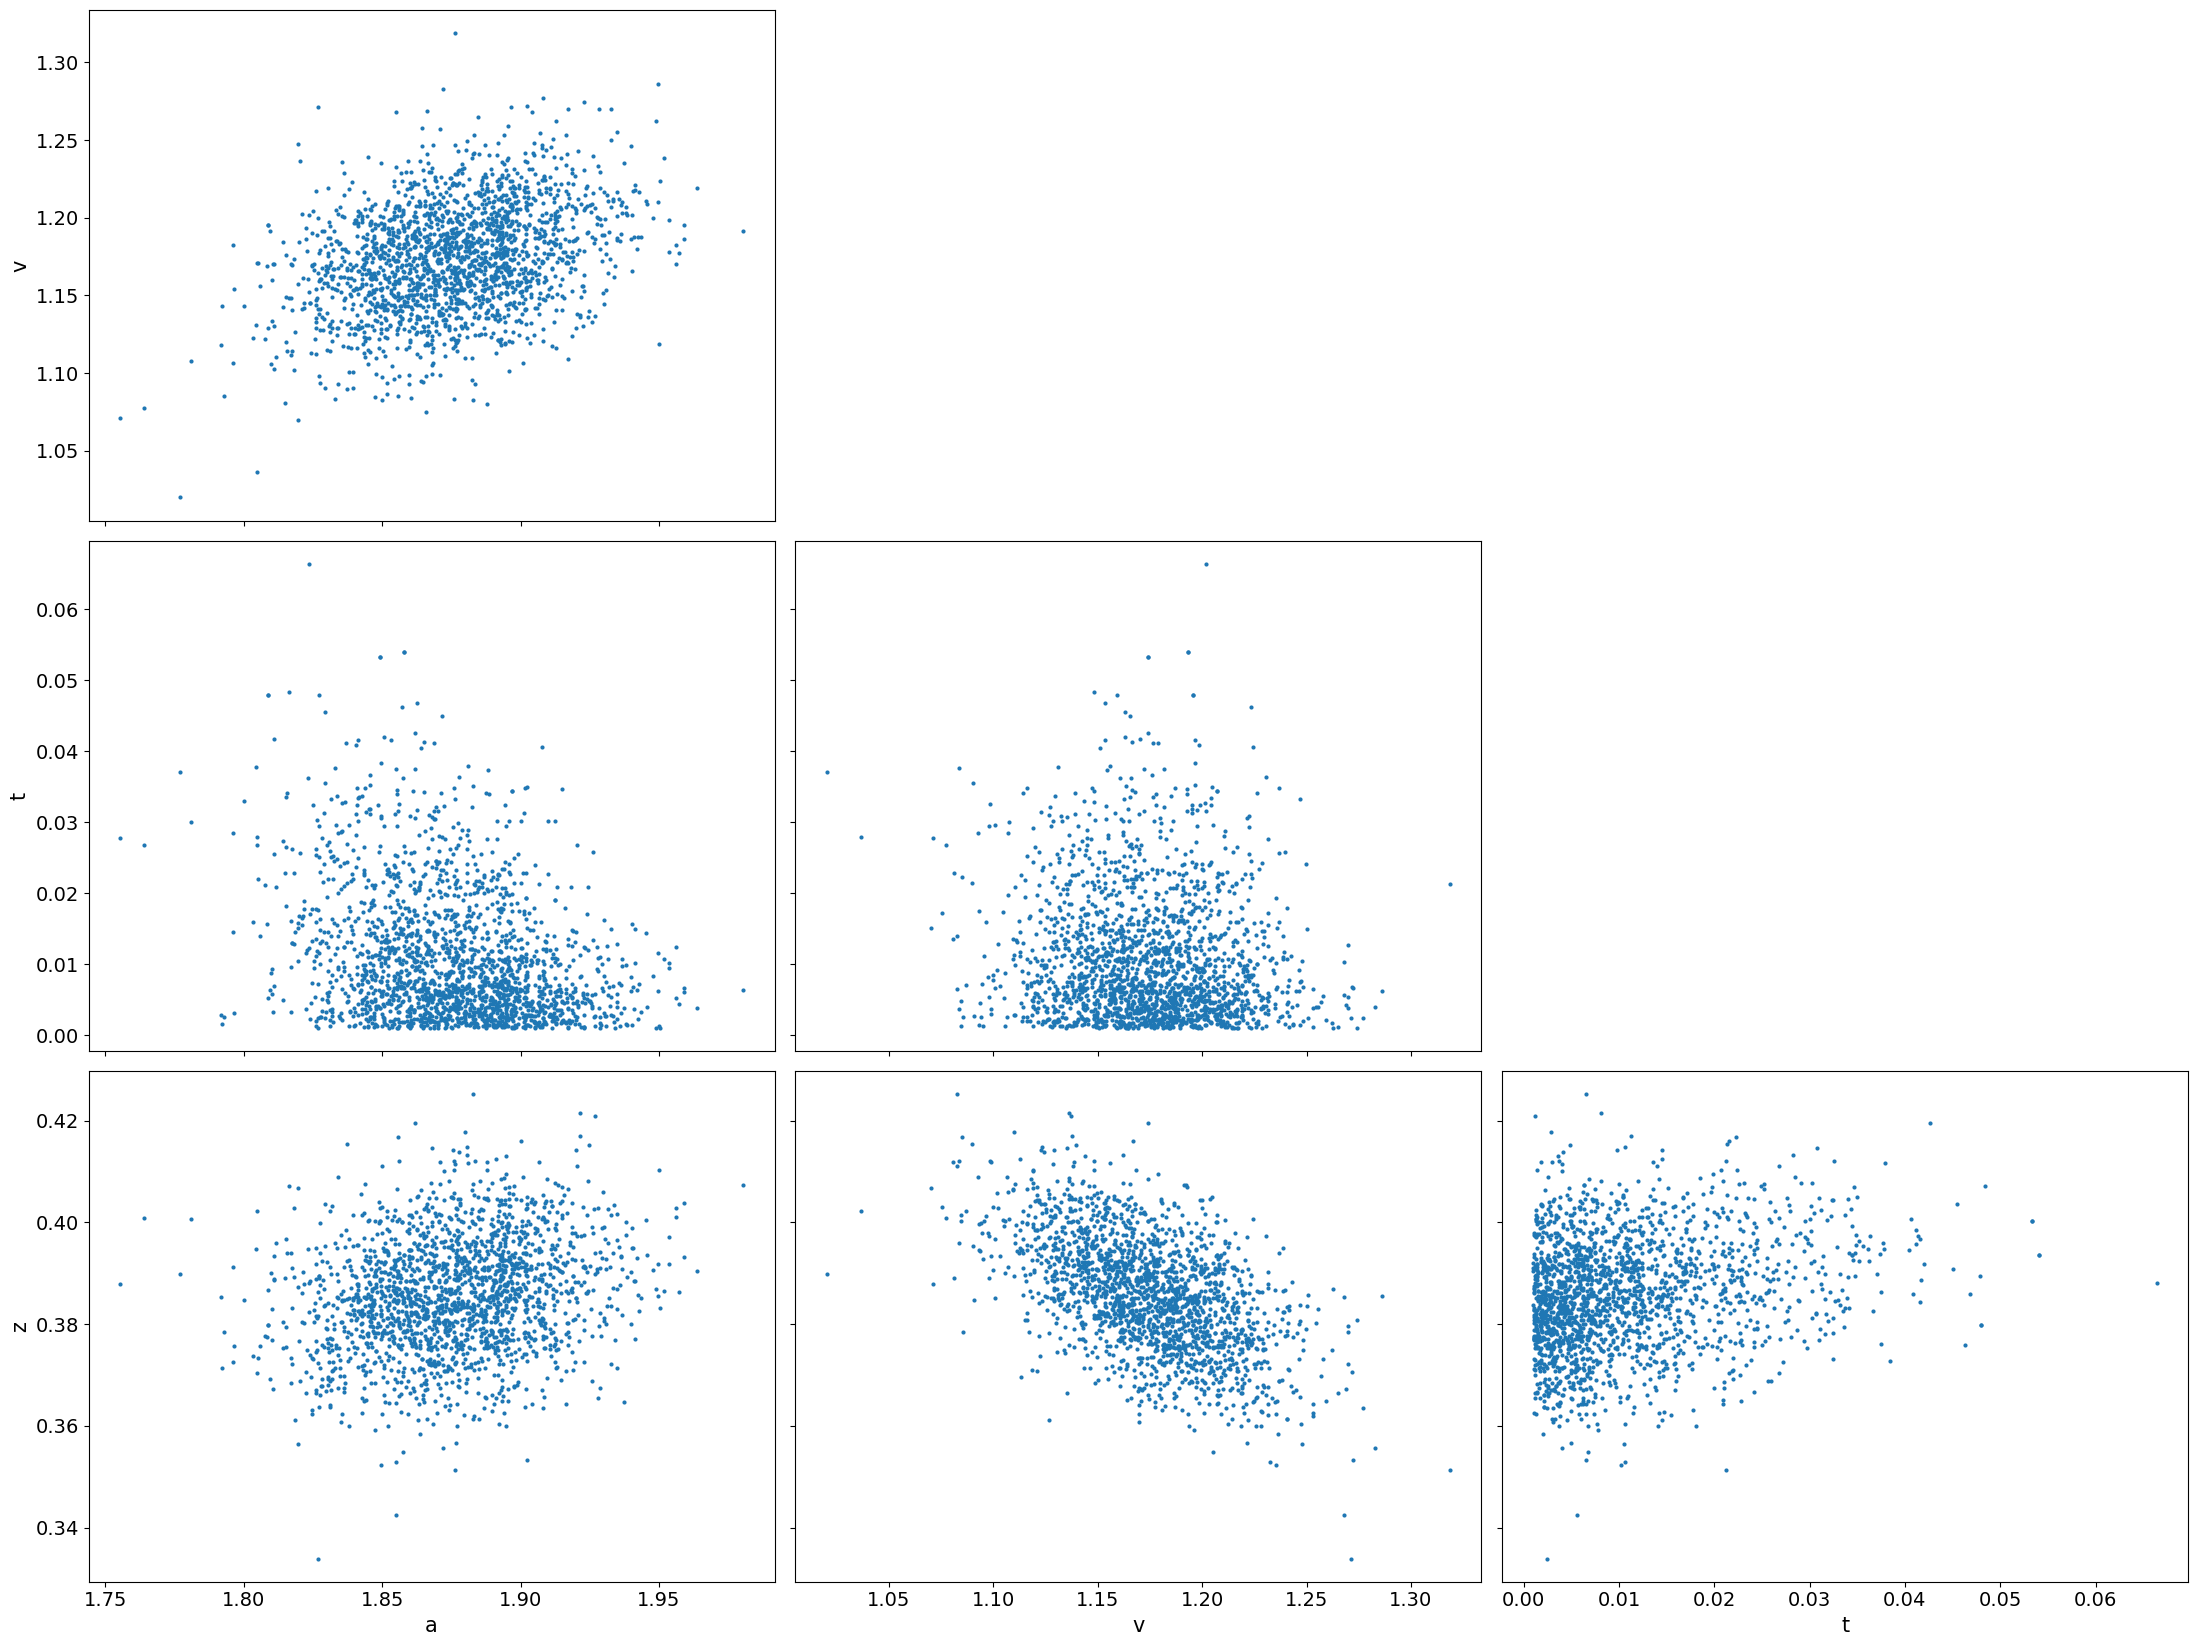

In [88]:
az.plot_trace(model.traces)
plt.tight_layout()

az.plot_pair(model.traces)
plt.tight_layout()